# Homework 5: Scene-Dependent Image Segmentation

The goal of this homework is to implement a model that seperates foreground and background objects for a specific scene.  
We will use the highway scene from the Change Detection dataset:  
http://jacarini.dinf.usherbrooke.ca/dataset2014#

![input image](highway/input/in001600.jpg "Title") ![gt image](highway/groundtruth/gt001600.png "Title")

The groundtruth images contain 5 labels namely
- 0 : Static
- 50 : Hard shadow
- 85 : Outside region of interest
- 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
- 255 : Motion

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import cv2

## Task 1: Create a custom (Pytorch) dataset


https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
You need to create a class that inherets from **from torch.utils.data.Dataset** and implements two methods:
- **def \_\_len\_\_(self)**:  returns the length of the dataset
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data x,y
    - x is the image as a float tensor of shape: $(3,H,W)$ 
    - y is the label image as a mask of shape: $(H,W)$ each pixel should contain the label 0 (background) or 1 (foreground). It is recommended to use the type torch.long
    
**Tips**:
- The first 470 images are not labeled. Just ignore these images. 
- If possible load all images into memory or evene directly to GPU to increase speed.
- You can change the resolution to fit your model or your memory
- Add data augmentation to increase the data size

In [31]:
def binarize(img):
    img = img > 0 
    bin_img = torch.tensor(img, dtype = torch.long)
    return bin_img

In [48]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, labels_dir, transform=None):
        self.imgs_dir = imgs_dir
        self.labels_dir = labels_dir
        self.transform = transform
        # get a list of the name of the images that are in the directory, the first 469 images are not labeled
        self.list_name_imgs = [file_name for file_name in os.listdir(imgs_dir)][469:]
        self.list_name_labels = [file_name for file_name in os.listdir(labels_dir)][469:]
    
    def __len__(self):
        return(len(self.list_name_labels))
    
    def __getitem__(self, idx): #index is an integer from 0 to 1230
        # 1. read input image
        img_path = os.path.join(self.imgs_dir, self.list_name_imgs[idx])
        img = Image.open(img_path)
        img_tensor = torch.from_numpy(np.array(img))
        # 2. read labeled image
        label_path = os.path.join(self.labels_dir, self.list_name_labels[idx])
        label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if self.transform: # binarize the image into 0 and 1
            label_img = self.transform(label_img)
        label_tensor = torch.from_numpy(np.array(label_img))
        return (img_tensor, label_tensor)

1231


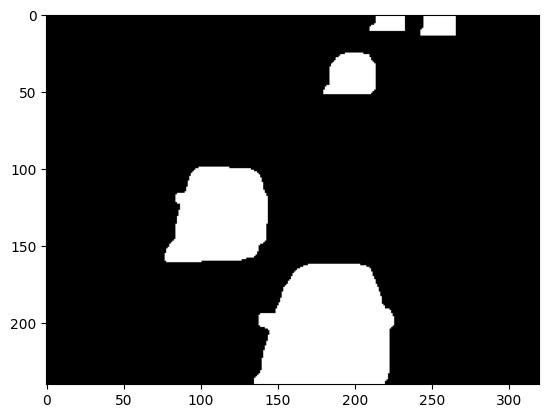

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [49]:
class_1 = CustomImageDataset(imgs_dir='./highway/input', labels_dir='./highway/groundtruth', transform=binarize)
print(class_1.__len__())
A = np.array(class_1.__getitem__(1220)[1])
plt.imshow(A, cmap="gray")
plt.show()
print(A)

## Task 2: Create a custom Segmentation Model

- input: a batch of images $(B,3,H,W)$ 
- output: a batch of pixel-wise class predictions $(B,C,H,W)$, where $C=2$

Tips:
- It is recommended to use a Fully-Convolutional Neural Network, because it flexible to the input and output resolution.
- Use Residual Blocks with convolutional layers.
- Base your model on established segmentation models:
    - U-Net: https://arxiv.org/abs/1505.04597
    - Deeplab: https://arxiv.org/abs/1606.00915

## Task 3: Create a training loop
- split data into training and test data, e.g. 80% training data and 20% test data using your custom dataset.
- Create a Dataloader for your custom datasets 
- Define a training loop for a single epoch:
    - forward pass
    - Loss function, e.g. cross entropy
    - optimizer 
    - backward pass
    - logging
- Define validation loop:
    - forward pass
    - extract binary labels, e.g. threshold or argmax for each pixel.
    - compute evaluation metrics: Accuracy, Precision, Recall and Intersection over Union for each image

## Task 4: Small Report of your model and training
- visualize training and test error over each epoch
- report the evaluation metrics of the final model